In [1]:
import hdf5plugin
import h5py    
import numpy as np  
import pandas as pd

In [2]:
def print_all_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            print(prefix + key)  # Print the dataset name
        elif isinstance(item, h5py.Group):
            print_all_datasets(item, prefix + key + '/')  # Recursively explore groups
            
def list_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, pd.DataFrame):
            print(prefix + key)  # Print the dataset path
        elif isinstance(item, pd.io.pytables.HDFStore):
            list_datasets(item, prefix + key + '/')  # Recursively explore groups


default_colors = {0: 'green', 1: 'blue', 2: 'orange', 3: 'red'}
import matplotlib.pyplot as plt
import matplotlib

In [3]:
region_name = 'SLC5A12_regions'
celltype = 'enterocytes'
fold = 'fold_0'
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

regions_df = pd.read_csv('region_scores/'+celltype+'/'+region_name+"/"+fold+".interpreted_regions.bed", sep='\t', names=NARROWPEAK_SCHEMA)

seq_length = 2114
regions_df['int_start'] = regions_df['start']+regions_df['summit']-seq_length/2
regions_df['int_end'] = regions_df['start']+regions_df['summit']+seq_length/2



In [4]:
def get_model_score(file_path,sequence_number):
    import h5py
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        dataset = f['shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get contribution_scores
        df = pd.DataFrame(dataset[sequence_number][:])
    
        # Access the dataset
        dataset = f['raw']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df2 = pd.DataFrame(dataset[sequence_number][:])
    df3 = df*df2

    return(df3)
        

In [5]:
sequence_number = 0
sequence_chr,sequence_start,sequence_end = regions_df.loc[sequence_number,'chr'],int(regions_df.loc[sequence_number,'int_start']),int(regions_df.loc[sequence_number,'int_end'])

folds = ['fold_0','fold_1','fold_2','fold_3','fold_4']
i = 0
for fold in folds:

    file_path = 'region_scores/'+celltype+'/'+region_name+"/"+fold+'.profile_scores.h5'
    dataset_key = '/projected_shap/seq'  # Adjust the dataset key as needed

    model_score_fold = get_model_score(file_path,sequence_number)
    if i == 0:
        model_score_sum = model_score_fold
        i+=1
    else:
        model_score_sum = model_score_sum + model_score_fold

model_score_avg = model_score_sum/len(folds)

In [6]:
seq_df = model_score_avg.T
seq_df.columns = ['A','C','G','T']

In [7]:
seq_df

,A,C,G,T
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
2109,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0
2111,0.0,0.0,0.0,0.0
2112,0.0,0.0,0.0,0.0


In [23]:

import numpy as np
# Generate a 100bp grid
grid = np.linspace(0, 2114, num=22)
# Round each grid value to the nearest multiple of 100
rounded_grid = np.round(grid / 100) * 100
# Add starting position
grid2 = [x+sequence_start for x in rounded_grid]
# Round to nearest multiple of 100
rounded_grid2 = np.round(np.array(grid2) / 100) * 100
rounded_grid2 = [int(x) for x in rounded_grid2]
#Reset locations
tick_locations = [x-sequence_start for x in rounded_grid2]
#Add chr to first tick
rounded_grid2 = [str(x) for x in rounded_grid2]
rounded_grid2[0] = sequence_chr+": " + str(rounded_grid2[0])

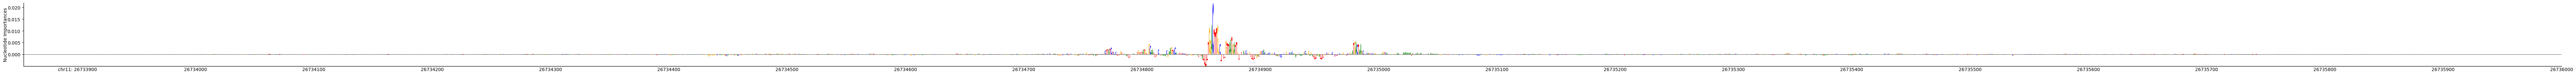

In [24]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df,figsize=(100, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/testing_avg_SLC.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [25]:
# Define a mapping for nucleotides
nucleotides = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
seq_nucs = [nucleotides[x] for x in df2.idxmax()]
seq_nucs = ''.join(seq_nucs)

snp_data = []
nucs = ['A','C','G','T']
i = 1
for x in seq_nucs:
    ref_all = x
    snp_data.append([sequence_chr,sequence_start+i,ref_all,'A'])
    snp_data.append([sequence_chr,sequence_start+i,ref_all,'C'])
    snp_data.append([sequence_chr,sequence_start+i,ref_all,'G'])
    snp_data.append([sequence_chr,sequence_start+i,ref_all,'T'])
    i+=1
#make 0-based
for x in range(0,len(snp_data)):
    snp_data[x][1] = snp_data[x][1]-1
    # Add more entries as needed
    
def write_bed(filename, bed_data):
    with open(filename, 'w') as bed_file:
        for entry in bed_data:
            bed_file.write('\t'.join(str(field) for field in entry) + '\n')

region_name = sequence_chr+"_"+str(sequence_start)+"-"+str(sequence_end)
write_bed('in_silico_mutagenesis/'+region_name+"_snps.bed", snp_data)

NameError: name 'df2' is not defined

In [107]:
region_name

'chr11_26733855-26735969'

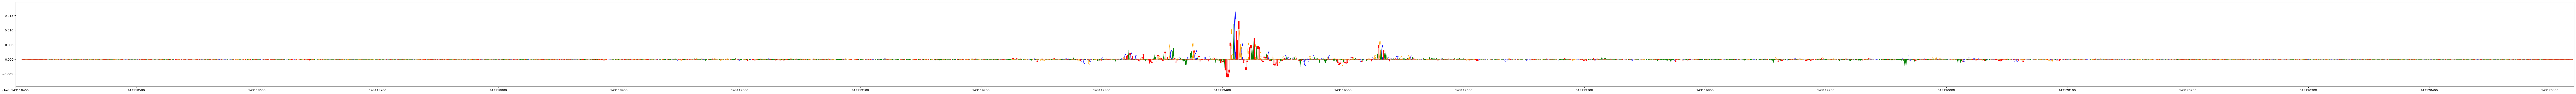

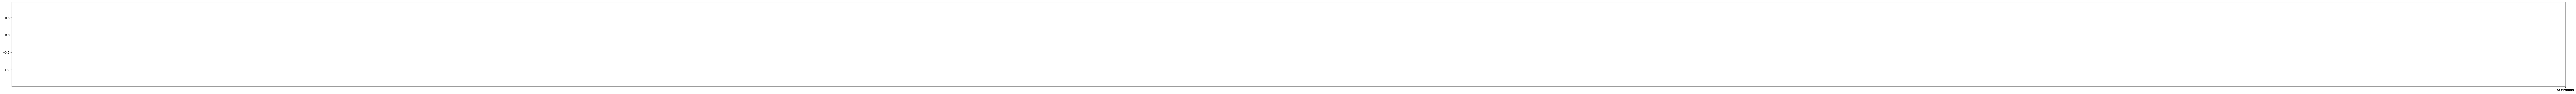

In [108]:
ISM_df = pd.read_csv("test_region_final_snps_ISM_chr11_26733855-26735969_snp_scores.tsv",sep="\t")
ISM_df['POS1'] = ISM_df['POS0']+1

plot_weights(array=df3.values,fig=plt.figure(figsize=(150,5)),n=1,n1=1,n2=1,)
plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("SLC5A12_chr11_26733855-26735969.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

colors_nc = {'A': 'green', 'C': 'blue', 'G': 'orange', 'T': 'red'}

plt.figure(figsize=(150,5))
for nc in ['A','C','G','T']:
    ISM_nc = ISM_df.loc[ISM_df['ALT']==nc]
    ISM_nc = ISM_nc.loc[ISM_nc['REF']!=nc]
    
    x,y = ISM_nc['POS1'],ISM_nc['log_counts_diff']
    
    plt.plot(x,y,'o',c=colors_nc[nc],markersize=1)
    
plt.xticks(ticks=[int(x) for x in rounded_grid2[1:]],labels = rounded_grid2[1:])
plt.savefig("SLC5A12_chr11_26733855-26735969_SNPs.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()


In [6]:
ISM_df = pd.read_csv("test_region_final_snps_ISM_chr11_26733855-26735969_snp_scores.tsv",sep="\t")
ISM_df['POS1'] = ISM_df['POS0']+1


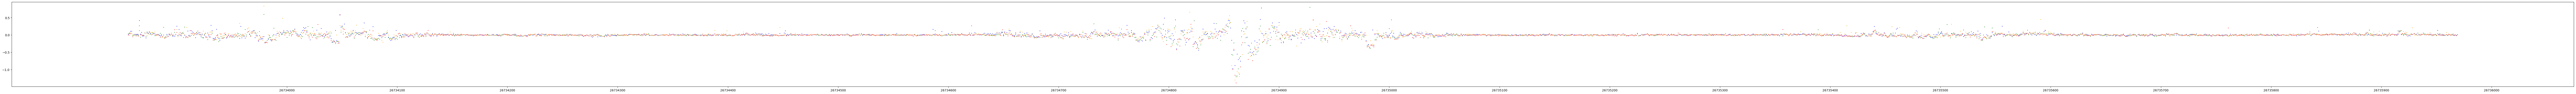

In [113]:
plt.figure(figsize=(150,5))
for nc in ['A','C','G','T']:
    ISM_nc = ISM_df.loc[ISM_df['ALT']==nc]
    ISM_nc = ISM_nc.loc[ISM_nc['REF']!=nc]
    
    x,y = ISM_nc['POS1'],ISM_nc['log_counts_diff']
    
    plt.plot(x,y,'o',c=colors_nc[nc],markersize=1)
    
plt.xticks(ticks=[int(x) for x in rounded_grid2[1:]],labels = rounded_grid2[1:])
plt.savefig("SLC5A12_chr11_26733855-26735969_SNPs.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()


In [114]:
ISM_df.loc[ISM_df['POS1']==26734448]

,CHR,POS0,REF,ALT,META_DATA,log_counts_diff,log_probs_diff_abs_sum,probs_jsd_diff,POS1
2368,chr11,26734447,G,A,NaN,-0.007622,-20.781200,-0.009368,26734448
2369,chr11,26734447,G,C,NaN,-0.009139,-22.656082,-0.009499,26734448
2370,chr11,26734447,G,G,NaN,0.000000,0.000000,0.000000,26734448
2371,chr11,26734447,G,T,NaN,-0.009467,-30.560154,-0.013132,26734448


In [115]:
ISM_df.loc[ISM_df['POS1']==26735116]

,CHR,POS0,REF,ALT,META_DATA,log_counts_diff,log_probs_diff_abs_sum,probs_jsd_diff,POS1
5040,chr11,26735115,G,A,NaN,-0.005704,-10.731412,-0.007737,26735116
5041,chr11,26735115,G,C,NaN,-0.013273,-11.292250,-0.007643,26735116
5042,chr11,26735115,G,G,NaN,0.000000,0.000000,0.000000,26735116
5043,chr11,26735115,G,T,NaN,-0.011232,-10.505995,-0.008018,26735116


In [116]:
ISM_df = pd.read_csv("test_region_final_snps_ISM_chr6_143118405-143120519_snp_scores.tsv",sep="\t")
ISM_df['POS1'] = ISM_df['POS0']+1

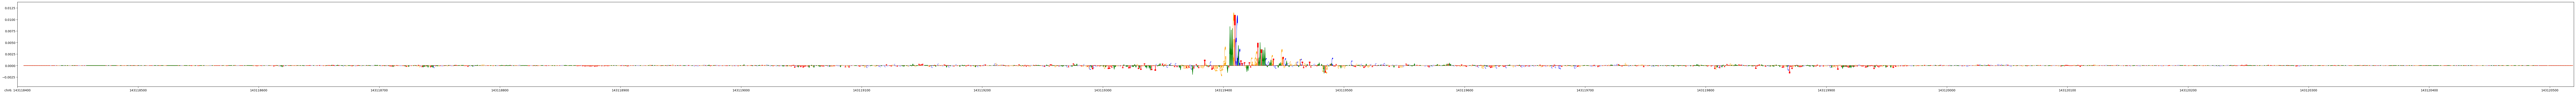

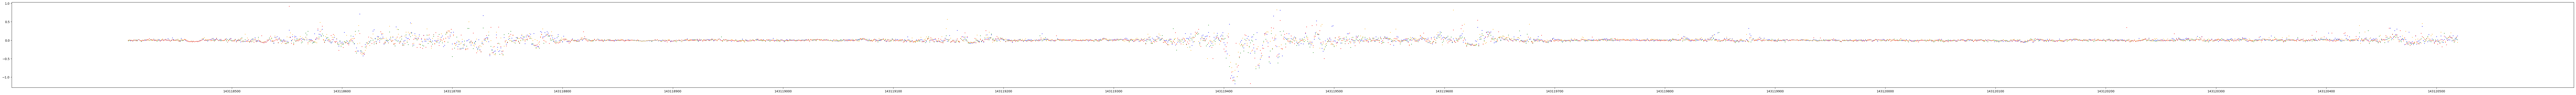

In [98]:
plot_weights(array=df3.values,fig=plt.figure(figsize=(150,5)),n=1,n1=1,n2=1,)
plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("AIG_chr6_143118405-143120519.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

colors_nc = {'A': 'green', 'C': 'blue', 'G': 'orange', 'T': 'red'}

plt.figure(figsize=(150,5))
for nc in ['A','C','G','T']:
    ISM_nc = ISM_df.loc[ISM_df['ALT']==nc]
    ISM_nc = ISM_nc.loc[ISM_nc['REF']!=nc]
    
    x,y = ISM_nc['POS1'],ISM_nc['log_counts_diff']
    
    plt.plot(x,y,'o',c=colors_nc[nc],markersize=1)
    
plt.xticks(ticks=[int(x) for x in rounded_grid2[1:]],labels = rounded_grid2[1:])
plt.savefig("AIG_chr6_143118405-143120519_SNPs.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()


In [100]:
ISM_df.loc[ISM_df['POS1']==143119432]
#hg38 - chr6:143119432; modern human is T, chimp/gorilla is C


,CHR,POS0,REF,ALT,META_DATA,log_counts_diff,log_probs_diff_abs_sum,probs_jsd_diff,POS1
4104,chr6,143119431,T,A,NaN,-0.745495,-212.66914,-0.091714,143119432
4105,chr6,143119431,T,C,NaN,-0.690768,-183.88394,-0.079792,143119432
4106,chr6,143119431,T,G,NaN,-0.638319,-177.06396,-0.078013,143119432
4107,chr6,143119431,T,T,NaN,0.000000,0.00000,0.000000,143119432
